In [1]:
!mkdir results  # 결과를 저장할 폴더 생성 (터미널 명령)

In [2]:
!mkdir results  # 결과를 저장할 폴더 생성 (터미널 명령)

import torch                              # PyTorch 라이브러리 전체
import torchvision                         # 이미지 데이터셋과 모델 제공 라이브러리
import torchvision.transforms as transforms # 이미지 전처리(변환) 도구
import torch.nn as nn                       # 신경망 모듈 정의 도구
import torch.nn.functional as F             # 활성화 함수 등 함수형 API
import torch.optim as optim                 # 최적화 알고리즘
import argparse                             # 커맨드라인 옵션 처리
import numpy as np                          # 수치 계산 라이브러리
import time                                 # 시간 측정을 위한 모듈
from copy import deepcopy                   # 객체 복사(하이퍼파라미터 실험용)
import seaborn as sns                       # 통계형 시각화 도구
import matplotlib.pyplot as plt             # 그래프 그리기 도구

mkdir: cannot create directory ‘results’: File exists


In [3]:
# ======== 데이터 전처리 설정 ========
transform = transforms.Compose([
    transforms.ToTensor(),                 # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5),  # 채널별 평균 값으로 정규화
                         (0.5, 0.5, 0.5))  # 채널별 표준편차로 정규화
])

In [4]:
# ======== 데이터셋 로드 ========
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform)                   # 학습용 CIFAR-10 데이터

# 학습용 데이터를 40,000장 학습(train), 10,000장 검증(val)으로 분할
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform)                   # 테스트용 CIFAR-10 데이터

# 데이터셋 모음을 딕셔너리로 정리
partition = {'train': trainset, 'val': valset, 'test': testset}

100%|██████████| 170M/170M [00:01<00:00, 98.4MB/s]


In [5]:
# ======== MLP(다층 퍼셉트론) 모델 정의 ========
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer,
                 act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        # 입력 차원, 출력 차원, 은닉 유닛 수, 레이어 수 등 변수 저장
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # 첫 번째 선형 레이어: in_dim -> hid_dim
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        # 은닉 레이어 묶음(ModuleList)
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            # hid_dim -> hid_dim 레이어 추가
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                # 배치 정규화 레이어 선택적 추가
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
        
        # 최종 출력 레이어: hid_dim -> out_dim
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # 활성화 함수 설정 (relu, tanh, sigmoid)
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('유효한 활성화 함수가 아닙니다!')
        
        # 드롭아웃 레이어 설정
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            # 가중치 초기화 실행
            self.xavier_init()
          
    def forward(self, x):
        # 순전파: 입력->fc1->활성화->은닉 레이어 반복->드롭아웃->출력 레이어
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        # 각 선형 레이어 가중치를 Xavier 분포로 초기화
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

In [6]:
# ======== VGG 스타일 설정(cfg) ========
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


In [7]:
# ======== CNN(합성곱 신경망) 모델 정의 ========
class CNN(nn.Module):
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()
        # 활성화 함수 선택
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError('유효한 활성화 함수 코드가 아닙니다')
        
        # cfg[model_code] 기반으로 합성곱/풀링 레이어 묶음 생성
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        # 마지막 분류기: 512->256->out_dim
        self.classifer = nn.Sequential(
            nn.Linear(512, 256), self.act,
            nn.Linear(256, out_dim)
        )
        
    def forward(self, x):
        x = self.layers(x)           # 합성곱+풀링 통과
        x = x.view(x.size(0), -1)    # [B, C, H, W] -> [B, features]
        x = self.classifer(x)        # 완전연결 분류기
        return x
        
    def _make_layers(self, code, in_channels, use_bn):
        layers = []
        for x in cfg[code]:
            if x == 'M':
                # 'M'이면 맥스풀링
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                # 아니면 Conv2d(+배치정규화+활성화)
                layers += [nn.Conv2d(in_channels, x, kernel_size=3,
                                     stride=1, padding=1)]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                in_channels = x
        return nn.Sequential(*layers)

In [8]:
# ======== 간단 CNN1 모델 예시 ========
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # 두 개의 합성곱 레이어 정의
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 5, stride=1, padding=2)
        self.act = nn.ReLU()             # ReLU 활성화
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(65536, 10)   # 풀링 후 펼쳐서 -> 10 클래스

    def forward(self, x):
        x = self.act(self.conv1(x))      # conv1->ReLU
        x = self.act(self.conv2(x))      # conv2->ReLU
        x = self.maxpool1(x)             # 풀링
        x = x.view(x.size(0), -1)        # 펼치기
        x = self.fc(x)                   # 최종 분류
        return x

In [9]:
# ======== 입력/출력 차원 확인 유틸 ========
def dimension_check():
    net = CNN('VGG11', 3, out_dim=10, act='relu', use_bn=True)
    x = torch.randn(2, 3, 32, 32)     # 더미 배치 생성
    y = net(x)
    print(y.size())                   # 예상 출력: [2, 10]

dimension_check()

torch.Size([2, 10])


In [10]:
# ======== 학습 함수 ========
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(
        partition['train'], batch_size=args.train_batch_size,
        shuffle=True, num_workers=2)
    net.train()                        # 모델을 학습 모드로 전환

    correct = total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()          # 이전 기울기 초기화

        inputs, labels = data          # 배치 데이터 언패킹
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)          # 순전파

        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()               # 기울기 계산
        optimizer.step()              # 가중치 업데이트

        train_loss += loss.item()     # 손실 합산
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 평균 손실과 정확도 계산
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [11]:
# ======== 검증 함수 ========
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(
        partition['val'], batch_size=args.test_batch_size,
        shuffle=False, num_workers=2)
    net.eval()                        # 평가 모드로 전환

    correct = total = 0
    val_loss = 0
    with torch.no_grad():            # 기울기 계산 비활성화
        for data in valloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [12]:
# ======== 테스트 함수 ========
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(
        partition['test'], batch_size=args.test_batch_size,
        shuffle=False, num_workers=2)
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    return test_acc


In [13]:
# ======== 전체 실험 관리 함수 ========
def experiment(partition, args):
    # 모델 생성
    net = CNN(model_code=args.model_code,
              in_channels=args.in_channels,
              out_dim=args.out_dim,
              act=args.act,
              use_bn=args.use_bn)
    net.cuda()

    # 손실함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr,
                               weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr,
                                   weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr,
                                weight_decay=args.l2)
    else:
        raise ValueError('잘못된 optimizer 선택')
    
    # 결과 저장용 리스트 초기화
    train_losses, val_losses = [], []
    train_accs, val_accs   = [], []
    
    for epoch in range(args.epoch):  # 에포크 반복
        ts = time.time()            # 시작 시간
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc           = validate(net, partition, criterion, args)
        te = time.time()            # 종료 시간
        
        # 기록 저장
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # 로그 출력
        print(f"Epoch {epoch}, Acc(train/val): {train_acc:2.2f}/{val_acc:2.2f},"
              f" Loss(train/val) {train_loss:2.2f}/{val_loss:2.2f}. Took {te-ts:2.2f} sec")
        
    # 최종 테스트 정확도 확인
    test_acc = test(net, partition, args)    
    
    # 결과 딕셔너리에 저장
    result = { 'train_losses': train_losses,
               'val_losses'  : val_losses,
               'train_accs'  : train_accs,
               'val_accs'    : val_accs,
               'train_acc'   : train_acc,
               'val_acc'     : val_acc,
               'test_acc'    : test_acc }
    return vars(args), result

In [14]:
# ======== 실험 결과 파일 저장/불러오기 ========
import hashlib, json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch'], setting['test_batch_size']
    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = f'./results/{exp_name}-{hash_key}.json'
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    files = [f for f in listdir(dir_path)
             if isfile(join(dir_path, f)) and '.json' in f]
    list_result = []
    for filename in files:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                list_result.append(json.load(infile))
    return pd.DataFrame(list_result)


In [15]:
# ======== 결과 시각화 함수 ========
def plot_acc(var1, var2, df):
    fig, axes = plt.subplots(1,3, figsize=(15,6))
    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=axes[0])
    sns.barplot(x=var1, y='val_acc',   hue=var2, data=df, ax=axes[1])
    sns.barplot(x=var1, y='test_acc',  hue=var2, data=df, ax=axes[2])
    axes[0].set_title('Train Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):
    # 학습/검증 손실 변화 시각화
    list_data = []
    for v1 in df[var1].unique():
        for v2 in df[var2].unique():
            row = df[(df[var1]==v1)&(df[var2]==v2)].iloc[0]
            for e, tl in enumerate(row.train_losses):
                list_data.append({'type':'train','loss':tl,'epoch':e,var1:v1,var2:v2})
            for e, vl in enumerate(row.val_losses):
                list_data.append({'type':'val','loss':vl,'epoch':e,var1:v1,var2:v2})
    plot_df = pd.DataFrame(list_data)
    g = sns.FacetGrid(plot_df, row=var2, col=var1, hue='type', **kwargs)
    g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    # 학습/검증 정확도 변화 시각화
    list_data = []
    for v1 in df[var1].unique():
        for v2 in df[var2].unique():
            row = df[(df[var1]==v1)&(df[var2]==v2)].iloc[0]
            for e, ta in enumerate(row.train_accs):
                list_data.append({'type':'train','Acc':ta,'epoch':e,var1:v1,var2:v2,'test_acc':row.test_acc})
            for e, va in enumerate(row.val_accs):
                list_data.append({'type':'val','Acc':va,'epoch':e,var1:v1,var2:v2,'test_acc':row.test_acc})
    plot_df = pd.DataFrame(list_data)
    g = sns.FacetGrid(plot_df, row=var2, col=var1, hue='type', **kwargs)
    g.map(plt.plot, 'epoch', 'Acc', marker='.')
    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        txt = f"Test Acc: {list(metric.values)[0]:1.3f}"
        plt.text(0.05,0.95, txt, transform=plt.gca().transAxes,
                 bbox=dict(facecolor='yellow', alpha=0.5, boxstyle='round,pad=0.1'))
    g.map(show_acc, 'epoch','Acc','test_acc')
    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)


In [16]:
# ======== 랜덤 시드 고정 ========
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# ======== 커맨드라인 인자 설정 ========
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ======== 모델 및 학습 설정 ========
args.model_code        = 'VGG11'
args.in_channels       = 3
args.out_dim           = 10
args.act               = 'relu'
args.l2                = 1e-5
args.use_bn            = True
args.optim             = 'RMSprop'
args.lr                = 0.0015
args.epoch             = 10
args.train_batch_size  = 256
args.test_batch_size   = 1024

# ======== 실험 변수 정의 ========
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0001, 0.00001]
list_var2 = ['VGG11', 'VGG13']

# ======== 반복 실험 수행 ========
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr_model_code', model_code='VGG11', in_channels=3, out_dim=10, act='relu', l2=1e-05, use_bn=True, optim='RMSprop', lr=0.0001, epoch=10, train_batch_size=256, test_batch_size=1024)
Epoch 0, Acc(train/val): 50.90/50.29, Loss(train/val) 1.33/1.51. Took 13.20 sec
Epoch 1, Acc(train/val): 71.07/60.57, Loss(train/val) 0.81/1.18. Took 11.12 sec
Epoch 2, Acc(train/val): 80.08/56.25, Loss(train/val) 0.57/1.46. Took 11.01 sec
Epoch 3, Acc(train/val): 87.15/68.16, Loss(train/val) 0.37/1.06. Took 11.37 sec
Epoch 4, Acc(train/val): 92.58/58.36, Loss(train/val) 0.22/1.79. Took 11.26 sec
Epoch 5, Acc(train/val): 95.75/62.82, Loss(train/val) 0.13/1.61. Took 11.38 sec
Epoch 6, Acc(train/val): 96.76/62.82, Loss(train/val) 0.10/1.95. Took 11.45 sec
Epoch 7, Acc(train/val): 97.41/67.95, Loss(train/val) 0.08/1.51. Took 11.45 sec
Epoch 8, Acc(train/val): 97.81/70.60, Loss(train/val) 0.07/1.38. Took 11.77 sec
Epoch 9, Acc(train/val): 97.85/64.71, Loss(train/val) 0.06/2.00. Took 11.93

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


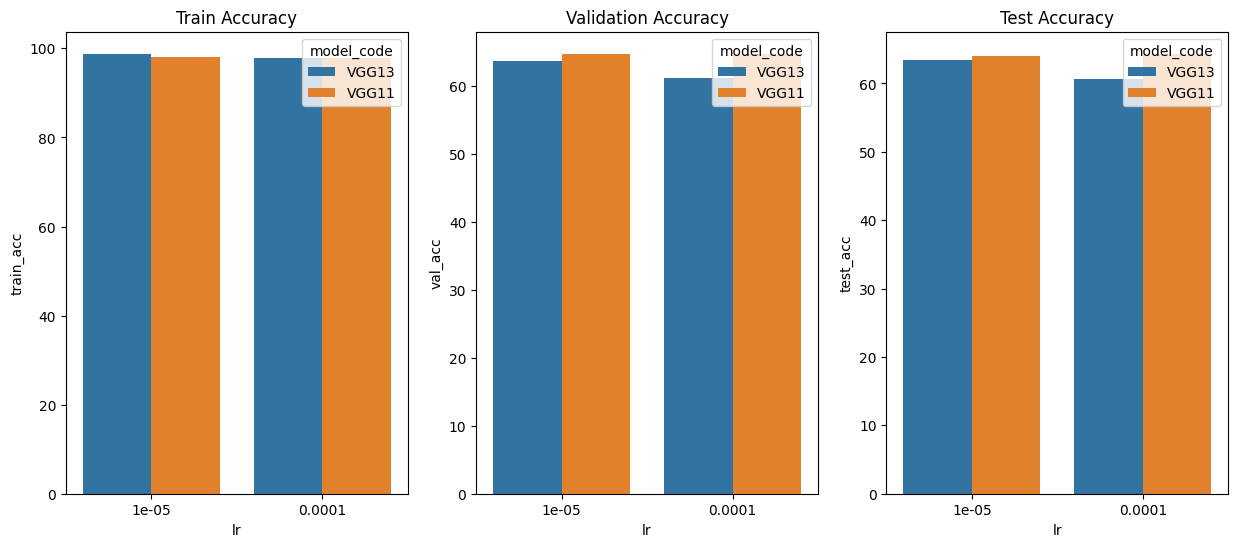

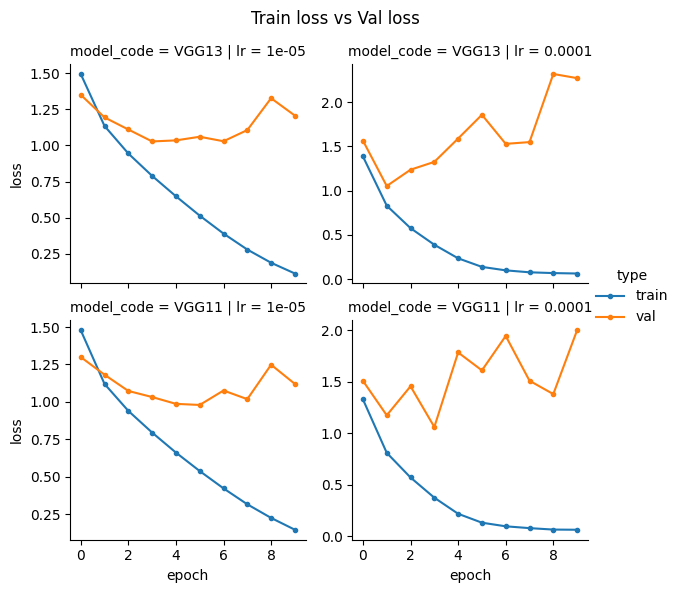

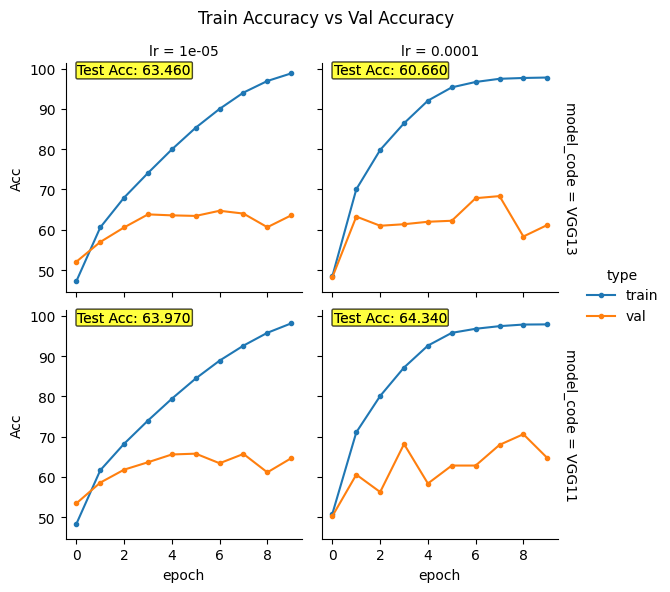

In [17]:
var1 = 'lr'
var2 = 'model_code'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.